In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

1) Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241.

In [2]:
data = pd.read_csv('gbm-data.csv')
data.head(2)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0


In [3]:
X = data.loc[:, 'D1':].values
y = data['Activity'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

2) Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:
* Используйте метод staged_decision_function для предсказания качества на обучающей и тестовой выборке на каждой итерации.
* Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле 1 / (1 + e^{−y_pred}), где y_pred — предсказанное значение.
* Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции sklearn.metrics.log_loss) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.

In [5]:
# сигмоида
def sigmoid(y_pred):
    return 1.0 / (1.0 + np.exp(-y_pred))

In [6]:
# используем log-loss в качестве функции потерь
def log_loss_pred(model, X, y):
    results = []
    for pred in model.staged_decision_function(X):
        results.append(log_loss(y, [sigmoid(y_pred) for y_pred in pred]))
    
    return results

In [7]:
# график значений log-loss
def plot_loss(learning_rate, train_loss, test_loss):
    plt.figure()
    plt.plot(train_loss, color='r', linewidth=2, alpha=.5,)
    plt.plot(test_loss, color='b', linewidth=2, alpha=.5,)
    plt.legend(['train', 'test'])
    
    min_loss_value = min(test_loss)
    min_loss_index = test_loss.index(min_loss_value)
        
    return min_loss_value, min_loss_index

In [8]:
# модель GradientBoostingClassifier
def gbc_model(learning_rate):
    gbc = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=250, random_state=241)
    gbc.fit(X_train, y_train)
    
    train_loss = log_loss_pred(gbc, X_train, y_train)
    test_loss = log_loss_pred(gbc, X_test, y_test)
    
    return plot_loss(learning_rate, train_loss, test_loss)

Wall time: 1min 58s


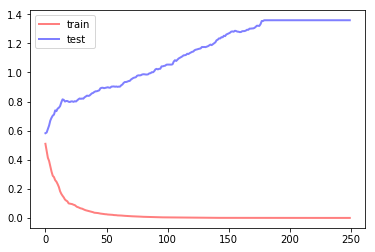

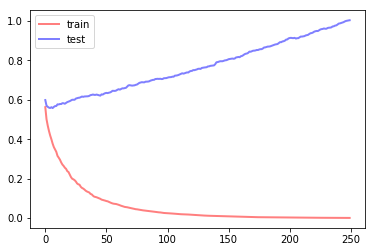

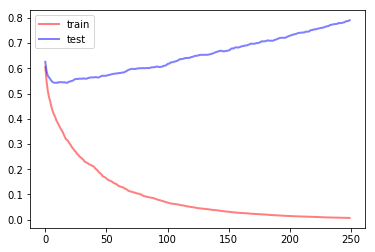

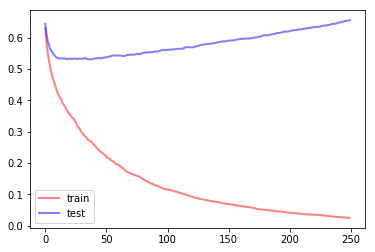

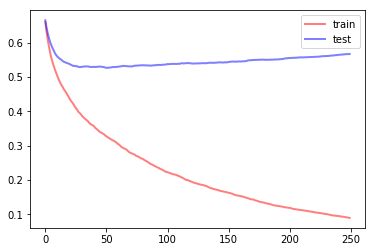

In [9]:
%%time
min_loss_results = {}
for learning_rate in [1, .5, .3, .2, .1]:
    min_loss_results[learning_rate] = gbc_model(learning_rate)

3) Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? В ответе укажите одно из слов overfitting либо underfitting.

In [10]:
#Overfitting

4) Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

In [11]:
min_loss_results[0.2]

(0.53109463759688502, 36)

5) На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно)

In [12]:
rfc = RandomForestClassifier(n_estimators=36, random_state=241).fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)[:, 1]
log_loss(y_test, y_pred)

0.54138128618040693